In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import click 
import umap
import os

2023-12-09 09:40:57.466975: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/DAVIDSON/dmkurdydyk/.conda/envs/aot/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Base directory
base_dir = os.getcwd()

# Paths
data_raw_where = base_dir + '/data/' # where the raw data(before sampling) were stored
data_sampled_where = base_dir + '/data/data_sampled' # where the sampled data were stored
weights_path = base_dir + '/new_weights/' # where the weights were stored
predict_where = base_dir + '/new_one_class_SVM_predict/' # Where to save predictions
umap_where = base_dir + '/umap_plots/' # where to save umap plots

# Constants
ISOTOPE = 'fission'
folder = base_dir + '/datalessthan5/'
sample_size = 512 # sample size = num_points 
d_max = 1024 # Size of latent Space


In [5]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)
def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)
    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))
    
    def get_config(self):
        return {'l2reg': self.l2reg,
               'num_features': self.num_features,
               'eye': self.eye.numpy().tolist()}
    
def tnet(inputs, num_features):
    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)
    
    x = conv_bn(inputs, 64) #64->32
    x = conv_bn(x, 128) #128 -> 64
    x = conv_bn(x, 1024) #1024 -> 512
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 512) # 512 -> 256
    x = dense_bn(x, 256) #256 -> 128
        
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

def pnet(sem_seg_flag, num_points, num_classes, dimension):
    #Since current number of classes is about 1/4 of pointnet, used 1/4 of size for all layers except initial 3 for input (x,y,z)    
    inputs = keras.Input(shape=(num_points, dimension))
    a = tnet(inputs, dimension)
    #print(a.shape)
    
    b = conv_bn(a, 64) # 64 -> 32
    c = conv_bn(b, 64) # 64 -> 32
    d = tnet(c, 64) #64 -> 32
    e = conv_bn(d, 64) # 64 -> 32
    f = conv_bn(e, 128) # 128 -> 64
    if d_max == 1024:
        x = conv_bn(f, 1024) #1024 -> 512
    elif d_max == 512:
        x = conv_bn(f,512)
    elif d_max == 2048:
        x = conv_bn(f,2048)
    
    global_features = layers.GlobalMaxPooling1D(name='global_features')(x)
    #return global_features

    if sem_seg_flag:
        x = tf.expand_dims(global_features, axis=1) #x -> global_features
        #print(x.shape)
        x = tf.repeat(x, repeats=num_points, axis=1)
        long = layers.Concatenate(axis=2)([d,x])
        x = conv_bn(long, 512) 
        x = conv_bn(x, 256)
        x = conv_bn(x, 128)
        x = layers.Dropout(0.3)(x)
        x = conv_bn(x, 128)
        x = layers.Dropout(0.3)(x)
        #outputs = conv_bn(x, num_classes)
        outputs = layers.Dense(num_classes, activation="sigmoid")(x)
        model = keras.Model(inputs=inputs, outputs=outputs, name="SemSegPointNet")
        model.summary()
    else:
        x = dense_bn(global_features, 512)  # 512 -> 256
        x = layers.Dropout(0.3)(x)
        x = dense_bn(x, 256)  # 256 -> 128
        x = layers.Dropout(0.3)(x)

        if num_classes == 2:
            # Use a single neuron for binary classification
            outputs = layers.Dense(1, activation="sigmoid")(x)
        else:
            # Use num_classes neurons for multi-class classification
            outputs = layers.Dense(num_classes, activation="softmax")(x)

        model = keras.Model(inputs=inputs, outputs=outputs, name="EventClassPointNet")
        model.summary()

    return model, global_features

In [6]:
# X, Y, Z, Charge, #points, Event Id
# first number - sample size (for ex. 512_sampled -> sample size = 512)
h5data = '512_sampled' # X, Y, charge as features
#h5data = '512_sampled_x' # Y, Z, Charge as features
#h5data = '512_sampled_y' # X, Z, Charge as features 
#h5data = '512_sampled_n' # X, Y,  num_points as features
#h5data = '512_sampled_ncx' #X, Charge, num_points
#h5data = '512_sampled_ncz' #Z, Charge, num_points
#h5data = '64_sampled' # X, Y, Charge 
#h5data = '32_sampled' # X, Y, Charge 
#h5data = '32_sampled_x' # Y, Z, Charge
#h5data = 'without_tresh' # X, Y, Charge
#h5data = 'data_20'
#h5data = 'data_250'
#h5data = '128_sampled' # X, Y, Charge 
# h5data = '256_sampled' #X, Y, Charge 
#h5data = 'with_n' # with  number of points (insted of x, for example)

##### Checkpoint

In [7]:
if h5data == 'without_tresh':
    data_raw1 = np.load(folder + ISOTOPE + '_size' + str(sample_size) + '_sampled.npy')
    data_without_charge = np.delete(data_raw1, (2,3,5))
    
    data_without_charge_y = np.copy(data_without_charge)
    data_without_charge_y = data_without_charge_y[:,:,(0,2)]

    data_without_charge_x = np.copy(data_without_charge)
    data_without_charge_x = data_without_charge_x[:,:,(1,2)]

    data_without_charge_z = np.copy(data_without_charge)
    data_without_charge_z = data_without_charge_z[:,:,(0,1)]
elif h5data == 'with_tresh':
    data_raw1 = np.load(data_sampled_where + 'with_tresh_sampled.npy')
    data_without_charge = np.delete(data_raw1, (3,4,5,6), axis = 2)# with event id
elif h5data == 'data_sampled':
    data_raw1 = np.load(data_sampled_where + 'index_sampled.npy')
    data_without_charge = np.delete(data_raw1, (3,4,5,6), axis = 2)# with event i
elif h5data == '512_sampled':
    data_raw1 = np.load(data_sampled_where + '512_sampled_old.npy')
    data_without_charge = np.delete(data_raw1, (2,4,5), axis = 2)# X, Y, Charge
elif h5data == '512_sampled_x':
    data_raw1 = np.load(data_sampled_where+'512_sampled_old.npy')
    data_without_charge = np.delete(data_raw1, (0,4,5), axis = 2)#  Y, Z, Charge
elif h5data == '512_sampled_y':
    data_raw1 = np.load(data_sampled_where+'512_sampled_old.npy')
    data_without_charge = np.delete(data_raw1, (1,4,5), axis = 2)#  X, Z, Charge
elif h5data == '512_sampled_n':
    data_raw1 = np.load(data_sampled_where+'512_sampled_old.npy')
    data_without_charge = np.delete(data_raw1, (2,3,5), axis = 2)#  X, Y, num_points
elif h5data == '512_sampled_ncx':
    data_raw1 = np.load(data_sampled_where+'512_sampled_old.npy')
    data_without_charge = np.delete(data_raw1, (1,2,5), axis = 2)#  X, charge, num_points
elif h5data == '512_sampled_ncz':
    data_raw1 = np.load(data_sampled_where+'512_sampled_old.npy')
    data_without_charge = np.delete(data_raw1, (0,1,5), axis = 2)
elif h5data == '64_sampled':
    data_raw1 = np.load(data_sampled_where+'64_sampled_old.npy')
    data_without_charge = np.delete(data_raw1, (2,4,5), axis = 2)# X, Y, Charge
elif h5data == '32_sampled':
    data_raw1 = np.load(data_sampled_where+'32_sampled_old.npy')
    data_without_charge = np.delete(data_raw1, (2,4,5), axis = 2)# with event i
elif h5data == '32_sampled_x':
    data_raw1 = np.load(data_sampled_where+'32_sampled_old.npy')
    data_without_charge = np.delete(data_raw1, (0,4,5), axis = 2)# with event i
elif h5data == 'data_250':
    data_raw1 = np.load(data_sampled_where+'250_sampled.npy')
    data_without_charge = np.delete(data_raw1, (2,4,5), axis = 2)# with event i
elif h5data == '128_sampled':
    data_raw1 = np.load(data_sampled_where+'128_sampled_old.npy')
    data_without_charge = np.delete(data_raw1, (2,4,5), axis = 2)# X, Y, Charge
elif h5data == '256_sampled':
    data_raw1 = np.load(data_sampled_where+'256_sampled_old.npy')
    data_without_charge = np.delete(data_raw1, (2,4,5), axis = 2)# with event i

##### Weights Types

In [8]:
#weights_type = 'random'
#weights_type = 'Mg22_without_charge_y'
#weights_type = 'Mg22_without_charge_x'
#weights_type = 'Mg22_without_charge_z'
#weights_type = 'Mg22_without_charge_z_10'
#weights_type = 'Mg22'
#weights_type = 'chair_without_charge_x'
#weights_type = 'chair_without_charge_y'
#weights_type = 'chair_without_charge_z'
#weights_type = 'chair_2_without_charge'
#weights_type = 'chair_2_without_charge_x'
#weights_type = 'chair_2_without_charge_y'
#weights_type = 'chair_2_without_charge_z'
#weights_type = 'dresser_chair'
#weights_type = 'dresser_chair_without_charge_x'
#weights_type = 'dresser_chair_without_charge_1024'
#weights_type = 'dresser_chair_without_charge_512_16'
#weights_type = 'dresser_chair_without_charge_512_8'
#weights_type = 'dresser_chair_without_charge_512_1'
#weights_type = 'dresser_chair_250'
#weights_type = 'dresser_chair_512_512'
#weights_type = 'dresser_chair_512_2048'
#weights_type = 'dresser_chair_512_1024'
#weights_type = 'dresser_chair_512_1024_x'
#weights_type = 'dresser_chair_512_1024_y'
#weights_type = 'dresser_chair_512_1024_n' # 
#weights_type = 'dresser_chair_512_1024_ncx' # #points, charge and x
#weights_type = 'dresser_chair_512_1024_ncz'
#weights_type = 'dresser_chair_512_1024_old' # use old data + new weights to be sure that weights isok
#weights_type = 'dresser_chair_32_1024'
#weights_type = 'dresser_chair_128_1024'
# weights_type = 'dresser_chair_256_1024'
#weights_type = 'dresser_chair_64_1024' # 64 - sample, 1024 - size of 1maxpool
#weights_type = 'dresser_chair_512_2048' #sample size + max p size
#weights_type = 'dresser_chair_375_1'
#weights_type = 'dresser_chair_512_1_512'
#weights_type = 'dresser_chair_512_1_2048'
#weights_type = 'dresser_chair_without_charge_x_512_1'
#weights_type = 'dresser_chair_without_charge_z_512_1'
#weights_type = 'dresser_chair_2_without_charge_512_1'
#weights_type = 'dresser_chair_without_charge_1024_16'
#weights_type = 'dresser_chair_without_charge_1024_1'
#weights_type = 'dresser_chair_without_charge_512'
#weights_type = 'dresser_chair_without_charge_256'
#weights_type = 'dresser_chair_without_charge_512_big'
#weights_type = 'dresser_chair_without_charge_512_big_2'
#weights_type = 'dresser_chair_without_charge_2048_32'
# weights_type = 'sofa_table'
#weights_type = 'sofa_table_without_charge_512_1'
#weights_type = 'chair_6_512_1'
#weights_type = 'dresser_chair_512_1_30'
#weights_type = 'Mg22_without_charge'
#data_type = 'with_charge'
data_type = 'without_charge'
#data_type = 'without_charge_y'
#data_type = 'without_charge_x'
#data_type = 'without_charge_z'

In [9]:
if data_type == 'with_charge':
    dimension = 4
elif data_type == 'without_charge':
    dimension = 3
elif data_type == 'without_charge_y':
    dimension = 2
elif data_type == 'without_charge_x':
    dimension = 2 
elif data_type == 'without_charge_z':
    dimension = 2 


In [10]:
num_points = sample_size

num_classes = 2 # 6 -> 2
nrand = 3

pretrain_model, global_features = pnet(sem_seg_flag = False, num_points = num_points, num_classes = num_classes, dimension = dimension)

#w_t = np.load('weights/weights_random_'+str(nrand)+'.npy', allow_pickle = True)
#pretrain_model.set_weights(w_t[:])

#model = keras.Model(inputs=pretrain_model.input, outputs=pretrain_model.get_layer('global_features').output, name="PointNet")

2023-12-09 09:42:09.915170: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-12-09 09:42:09.916406: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-12-09 09:42:09.933433: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-12-09 09:42:09.933452: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2023-12-09 09:42:09.933797: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-09 09:42:09.938249: I tensorflow/comp

Model: "EventClassPointNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 3)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 512, 64)      256         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 64)      256         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 64)      0           batch_normalization[0][0]        
_________________________________________________________________________________

In [12]:
# Check if weights_type is defined, if not, set a default
if 'weights_type' not in locals():
    weights_type = 'default'

weights_filenames = {
    'random': f'Random_weights_without_charge_{nrand}.npy',
    'Mg22': 'weights_Mg22_np.npy',
    'Mg22_without_charge': '22Mg_weights_without_charge.npy',
    'Mg22_without_charge_y': 'Mg22_weights_without_charge_y.npy',
    # Add other weight types here if you want to copy the earlier structure...
    'default': 'weights_dresser_chair_2_512_1_20_1024.npy'  # Default entry (add your type here if needed, check /new_weights)
}

# Get the filename from the dictionary, use default if not found
filename = weights_filenames.get(weights_type, weights_filenames['default'])

# Load the weights
w_t = np.load(weights_path + filename, allow_pickle=True)


In [13]:
for layer, weight in zip(pretrain_model.layers, w_t):
    if layer.get_weights() and (layer.weights[0].shape != weight.shape):
        print(f"Mismatch in layer {layer.name}: Expected {layer.weights[0].shape}, found {weight.shape}")

Mismatch in layer conv1d: Expected (1, 3, 64), found (64,)
Mismatch in layer conv1d_1: Expected (1, 64, 128), found (64,)
Mismatch in layer batch_normalization_1: Expected (128,), found (64,)
Mismatch in layer conv1d_2: Expected (1, 128, 1024), found (128,)
Mismatch in layer batch_normalization_2: Expected (1024,), found (128,)
Mismatch in layer dense: Expected (1024, 512), found (128,)
Mismatch in layer batch_normalization_3: Expected (512,), found (1, 128, 1024)
Mismatch in layer dense_1: Expected (512, 256), found (1024,)
Mismatch in layer batch_normalization_4: Expected (256,), found (1024,)
Mismatch in layer dense_2: Expected (256, 9), found (1024,)
Mismatch in layer conv1d_3: Expected (1, 3, 64), found (512,)
Mismatch in layer batch_normalization_5: Expected (64,), found (512,)
Mismatch in layer conv1d_4: Expected (1, 64, 64), found (512,)
Mismatch in layer batch_normalization_6: Expected (64,), found (512, 256)
Mismatch in layer conv1d_5: Expected (1, 64, 64), found (256,)
Misma

In [14]:
# Inspect model expected weight shapes
for layer in pretrain_model.layers:
    for weight in layer.weights:
        print(weight.name, weight.shape)

# Inspect loaded weight shapes
for weight in w_t:
    print(weight.shape)


conv1d/kernel:0 (1, 3, 64)
conv1d/bias:0 (64,)
batch_normalization/gamma:0 (64,)
batch_normalization/beta:0 (64,)
batch_normalization/moving_mean:0 (64,)
batch_normalization/moving_variance:0 (64,)
conv1d_1/kernel:0 (1, 64, 128)
conv1d_1/bias:0 (128,)
batch_normalization_1/gamma:0 (128,)
batch_normalization_1/beta:0 (128,)
batch_normalization_1/moving_mean:0 (128,)
batch_normalization_1/moving_variance:0 (128,)
conv1d_2/kernel:0 (1, 128, 1024)
conv1d_2/bias:0 (1024,)
batch_normalization_2/gamma:0 (1024,)
batch_normalization_2/beta:0 (1024,)
batch_normalization_2/moving_mean:0 (1024,)
batch_normalization_2/moving_variance:0 (1024,)
dense/kernel:0 (1024, 512)
dense/bias:0 (512,)
batch_normalization_3/gamma:0 (512,)
batch_normalization_3/beta:0 (512,)
batch_normalization_3/moving_mean:0 (512,)
batch_normalization_3/moving_variance:0 (512,)
dense_1/kernel:0 (512, 256)
dense_1/bias:0 (256,)
batch_normalization_4/gamma:0 (256,)
batch_normalization_4/beta:0 (256,)
batch_normalization_4/moving

In [15]:
pretrain_model.set_weights(w_t[:])

model = keras.Model(inputs=pretrain_model.input, outputs=pretrain_model.get_layer('global_features').output, name="PointNet")

if data_type == 'without_charge':
    train_feature = model.predict(data_without_charge, verbose=1)
    train_feature = StandardScaler().fit_transform(train_feature)
    
elif data_type == 'without_charge_y':
    train_feature = model.predict(data_without_charge_y, verbose=1)
    train_feature = StandardScaler().fit_transform(train_feature)
elif data_type == 'without_charge_x':
    train_feature = model.predict(data_without_charge_x, verbose=1)
    train_feature = StandardScaler().fit_transform(train_feature)
elif data_type == 'without_charge_z':
    train_feature = model.predict(data_without_charge_z, verbose=1)
    train_feature = StandardScaler().fit_transform(train_feature)


2023-12-09 09:50:24.170603: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-12-09 09:50:24.182921: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2200000000 Hz


2427/2427 [==============================] - 432s 178ms/step


In [16]:
# Set a default value for weights_type if it's not provided or empty
default_weights_type = 'weights_dresser_chair_2_512_1_20_1024'

# Check if weights_type is defined and not empty, otherwise use DEFAULT (MANUAL)
filename = weights_type if weights_type else default_weights_type

# Construct the complete path
full_path = f'{base_dir}/train_feat_output/train_feature_{default_weights_type}_weights.npy'

# Save the file
np.save(full_path, train_feature)


In [17]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(train_feature)

train_feature_without_shuffle = np.copy(train_feature)

np.random.shuffle(train_feature)
#train_feature_shuffle = np.load('train_feat_output/Shuffle_train_feature.npy')

# Parameters for OneClassSVM, best results for kernel = rbf, gamma = auto
kernel = 'rbf' 
#kernel = 'linear'
#kernel = 'poly'
gamma = 'auto'
#gamma = 'scale'
#gamma = 0.00001
degree = 3

num_of_predict = data_without_charge.shape[0]

train_feature_without_shuffle = train_feature_without_shuffle[:num_of_predict]
train_feature = train_feature[:num_of_predict] # slice num_of_predict = 77659

nu = np.array([0.01, 0.015, 0.02, 0.027, 0.03, 0.04, 0.06, 0.09])

num_of_train_exmp = np.array([1000,2000,10000])
#num_of_train_exmp = np.array([data_without_charge.shape[0]])


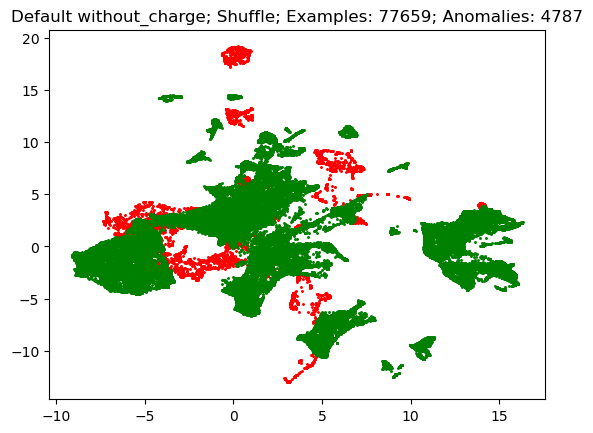

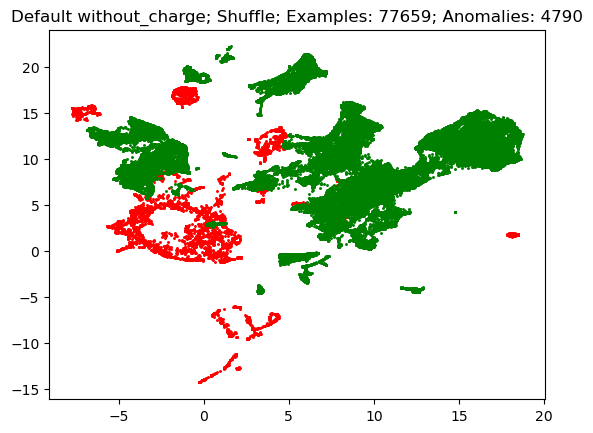

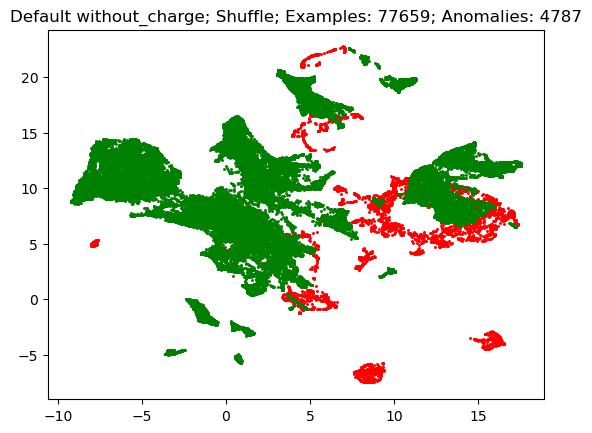

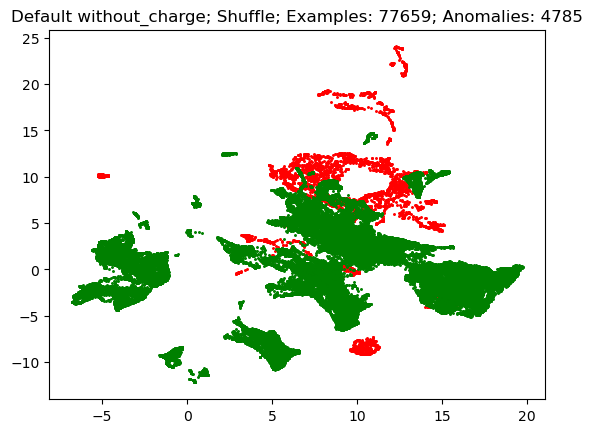

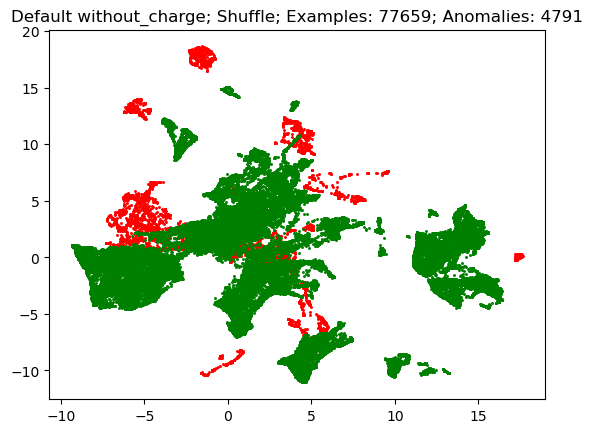

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [18]:
weights_type = weights_type if weights_type else default_weights_type

for j in num_of_train_exmp:
    num_of_train_ex = j
    train_feature_without_shuffle = train_feature_without_shuffle[:num_of_predict]
    train_feature = train_feature[:num_of_predict]

    for i in nu:
        clf = OneClassSVM(gamma=gamma, kernel=kernel, nu=i, degree=degree).fit(train_feature[:num_of_train_ex])
        predict_2 = clf.predict(train_feature_without_shuffle)

        # Construct the filename dynamically
        file_name_prefix = f'{weights_type}_'
        file_name_middle = ''
        if 'without_charge' in data_type:
            file_name_middle = {
                'without_tresh': '',
                'with_tresh': 'with_tresh_',
                'data_20': '20_',
                '512_sampled': '5_',
                'data_250': '250_',
                'with_n': 'with_n_'
            }.get(h5data, '')  # Default to empty string if h5data is not in the dictionary

        file_name_suffix = f'Shuffle_train_predict_{num_of_train_ex}_{num_of_predict}_kernel_{kernel}_gamma_{gamma}_nu_{i}'
        full_file_name = f'{predict_where}{file_name_prefix}{file_name_middle}{file_name_suffix}'

        # Save the file
        np.save(full_file_name, predict_2)
        
        anom_ind_2 = predict_2 == -1
        not_anom_ind_2 = predict_2 == 1

        anom_ind_2 = anom_ind_2.T # SAVE
        not_anom_ind_2 = not_anom_ind_2.T # SAVE

        anom_2 = train_feature_without_shuffle[anom_ind_2]
        not_anom_2 = train_feature_without_shuffle[not_anom_ind_2]

        anom_2 = reducer.fit_transform(anom_2)
        not_anom_2 = reducer.fit_transform(not_anom_2)

        plt.scatter(anom_2[:, 0], 
                anom_2[:, 1],
                marker = '.',
                s = 5,
                color = 'r')

        plt.scatter(not_anom_2[:, 0],
                not_anom_2[:, 1],
                marker = '.',
                s = 5,
                color = 'g')
        
        
        
        if 'without_charge' in data_type:
            title_part = f'{weights_type.replace("_", " ").capitalize()} {data_type}'
        else:
            title_part = f'{weights_type.capitalize()} Weights'

        if 'random' in weights_type and 'nrand' in locals():
            title_part += f' {nrand}'

        title = f'{title_part}; Shuffle; Examples: {num_of_predict}; Anomalies: {anom_2.shape[0]}'
        plt.title(title)
        plt.show()

        filename = f'{umap_where}{weights_type}_{data_type}_Shuffle_train_predict{num_of_train_ex}_' \
                   f'{num_of_predict}_kernel_{kernel}_gamma_{gamma}_nu_{i}_anom_{anom_2.shape[0]}.png'
        plt.savefig(filename)
